### Testing a sample of clipped images containing 2019 year data for both classes.

In [ ]:
import os
import gdown
import shutil
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import tensorflow as tf
# import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from tensorflow.keras.utils import save_img, img_to_array, array_to_img, load_img, image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
IS_COLAB = "google.colab" in str(get_ipython())

if IS_COLAB:
    small_data_dir = pathlib.Path("/content/content/small_subset")
else:
    # import os
    small_data_dir = pathlib.Path(os.getcwd()) / "Source/content/small_subset"

In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: syurt (syurt-institution) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
wandb.init(project='melanoma_classification', settings=wandb.Settings(code_dir=None))
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

In [ ]:
os.environ["WANDB_MODE"] = "dryrun"
os.environ["WANDB_DIR"] = "/dev/null"
os.environ["WANDB_DATA_DIR"] = "/dev/null"
os.environ["WANDB_CONFIG_DIR"] = "/dev/null"

In [ ]:
def show_dirs_len(path):
  for root, dirs, _ in os.walk(path):
    print(f"{os.path.relpath(root, path)}: {len(os.listdir(root))}")

## Формування робочого датасету

Завантаження джерела

In [ ]:
# https://drive.google.com/file/d/1Wn-z5ozhs94Pfgrix70CiCcQGZdTXh3z/view?usp=sharing
file_id = "1Wn-z5ozhs94Pfgrix70CiCcQGZdTXh3z"
url = f"https://drive.google.com/uc?id={file_id}"
output = "2020_supplemented_cropped.zip"

gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1Wn-z5ozhs94Pfgrix70CiCcQGZdTXh3z
From (redirected): https://drive.google.com/uc?id=1Wn-z5ozhs94Pfgrix70CiCcQGZdTXh3z&confirm=t&uuid=dce7b8d3-6d48-4916-afc7-6fb1c4680e47
To: /content/2020_supplemented_cropped.zip
100%|██████████| 1.59G/1.59G [00:22<00:00, 70.9MB/s]


'2020_supplemented_cropped.zip'

In [ ]:
!unzip -q 2020_supplemented_cropped.zip

In [ ]:
show_dirs_len(pathlib.Path("/content/content/2020_supplemented"))

.: 2
test: 2
test/melanoma: 1587
test/other: 10638
train: 2
train/melanoma: 5093
train/other: 32112


Завантаження додаткових зображень негативного класу (датасет 2019 train с темним фоном) - 2963 зображення.

In [ ]:
from google.colab import files
files.upload()

In [ ]:
# https://drive.google.com/file/d/1c0dSwX89B-YodSrKxns85mC2CSMVMfmi/view?usp=sharing
file_id = "1c0dSwX89B-YodSrKxns85mC2CSMVMfmi"
url = f"https://drive.google.com/uc?id={file_id}"
output = "vignette_cropped.zip"

gdown.download(url, output, quiet=False)
!unzip -q vignette_cropped.zip


Downloading...
From (original): https://drive.google.com/uc?id=1c0dSwX89B-YodSrKxns85mC2CSMVMfmi
From (redirected): https://drive.google.com/uc?id=1c0dSwX89B-YodSrKxns85mC2CSMVMfmi&confirm=t&uuid=a0edf505-f743-44d1-ae33-e2a9abb8b719
To: /content/vignette_cropped.zip
100%|██████████| 47.9M/47.9M [00:00<00:00, 81.4MB/s]


In [ ]:
show_dirs_len(pathlib.Path("/content/vignette_cropped"))

.: 2963


In [ ]:
# shutil.rmtree("/content/2020_supplemented_cropped")
# shutil.rmtree("/content/2019_train_other_split")

Завантаження зображень негативного класу (датасет 2019 test) для доповнення тестового набору.

In [ ]:
# https://drive.google.com/file/d/1Mgs7tFfJIgsbtZhm38pZh6wmbxQzZNPV/view?usp=sharing
file_id = "1Mgs7tFfJIgsbtZhm38pZh6wmbxQzZNPV"
url = f"https://drive.google.com/uc?id={file_id}"
output = "2019test.zip"

gdown.download(url, output, quiet=False)
!unzip -q 2019test.zip

Downloading...
From (original): https://drive.google.com/uc?id=1Mgs7tFfJIgsbtZhm38pZh6wmbxQzZNPV
From (redirected): https://drive.google.com/uc?id=1Mgs7tFfJIgsbtZhm38pZh6wmbxQzZNPV&confirm=t&uuid=f6266160-5342-4970-8bf5-567d70c67934
To: /content/2019test.zip
100%|██████████| 803M/803M [00:06<00:00, 115MB/s]


In [ ]:
!cp -r /content/2019test/other/* /content/content/2020_supplemented/test/other

In [ ]:
# show_dirs_len(pathlib.Path("/content/2020_supplemented"))
show_dirs_len(pathlib.Path("/content/content/2020_supplemented"))

.: 2
test: 2
test/melanoma: 1587
test/other: 17549
train: 2
train/melanoma: 5093
train/other: 32112


In [ ]:
data_dir = pathlib.Path("/content/content/2020_supplemented")

Функції для виділення з тренувального набору валідаційного, створення підвибірки датасету потрібного розміру.

In [ ]:
def make_sructured_subset(rate, source_path, dest_path, my_seed, copy=True):

  """create folder the same structure as source
     with of content files"""
  np.random.seed(my_seed)
  for root, dirs, files in os.walk(source_path):
    dirs.sort()
    files.sort()
    relative_path = os.path.relpath(root, source_path)
    new_folder = os.path.join(dest_path, relative_path)
    os.makedirs(new_folder, exist_ok=True)
    if files:
      num_files = int(len(files)*rate)
      files_to_copy = np.random.choice(files, num_files, replace=False)

      for filename in files_to_copy:
        src_file = os.path.join(root, filename)
        dest_file = os.path.join(new_folder, filename)
        if copy:
          shutil.copyfile(src_file, dest_file)
        else:
          shutil.move(src_file, dest_file)

In [ ]:
def make_balanced_sructured_subset(source_path, dest_path, my_seed, rates_per_class, copy=True):

  """create folder the same structure as source
     with part of content files, picked using different rate for selected folder:
      rate*k"""
  np.random.seed(my_seed)
  for root, dirs, files in os.walk(source_path):
    dirs.sort()
    files.sort()
    relative_path = os.path.relpath(root, source_path)
    class_name = os.path.basename(relative_path)
    if class_name in rates_per_class:
       rate = rates_per_class[class_name]
    else:
      rate = 0.2
    new_folder = os.path.join(dest_path, relative_path)
    os.makedirs(new_folder, exist_ok=True)
    if files:
      num_files = int(len(files)*rate)
      files_to_copy = np.random.choice(files, num_files, replace=False)

      for filename in files_to_copy:
        src_file = os.path.join(root, filename)
        dest_file = os.path.join(new_folder, filename)
        if copy:
          shutil.copyfile(src_file, dest_file)
        else:
          shutil.move(src_file, dest_file)

In [ ]:
def make_custom_sructured_subset(source_path, dest_path, my_seed, rates_per_ds, copy=True):

  """create folder the same structure as source
     with % of source folder files, randomly picked
     using different rate for each ds"""
  np.random.seed(my_seed)
  for root, dirs, files in os.walk(source_path):
    dirs.sort()
    files.sort()
    relative_path = os.path.relpath(root, source_path)
    new_folder = os.path.join(dest_path, relative_path)
    os.makedirs(new_folder, exist_ok=True)
    if files:
      for ds in rates_per_ds.keys():
        if ds in new_folder.split(os.sep):
          rate = rates_per_ds[ds]
          break
      num_files = int(len(files)*rate)
      files_to_copy = np.random.choice(files, num_files, replace=False)

      for filename in files_to_copy:
        src_file = os.path.join(root, filename)
        dest_file = os.path.join(new_folder, filename)
        if copy:
          shutil.copyfile(src_file, dest_file)
        else:
          shutil.move(src_file, dest_file)

In [ ]:
# select in validation directory equal size of classes
val_dir = data_dir / "validation"
train_dir = data_dir / "train"
num_melanoma = len(os.listdir(os.path.join(train_dir, "melanoma")))
num_other = len(os.listdir(os.path.join(train_dir, "other")))
k = num_melanoma/num_other if num_other > 0 else 1
print(k)
rates_per_class = {
    "melanoma": 0.2,
    "other": 0.2*k
}
make_balanced_sructured_subset(train_dir, val_dir, 10, rates_per_class, copy=False)

0.15860114598903838


In [ ]:
np.random.seed(42)
src_path =  pathlib.Path("/content/vignette_cropped")
dest_path = pathlib.Path("/content/content/2020_supplemented/validation/other")
shuffled_vignette_files = np.random.permutation(os.listdir(src_path))
for image in shuffled_vignette_files[:100]:
  shutil.move(src_path / image, dest_path / image)

In [ ]:
!cp -r /content/vignette_cropped/* /content/content/2020_supplemented/train/other

In [ ]:
show_dirs_len(data_dir)

.: 3
test: 2
test/melanoma: 1587
test/other: 17549
train: 2
train/melanoma: 4075
train/other: 33957
validation: 2
validation/melanoma: 1018
validation/other: 1118


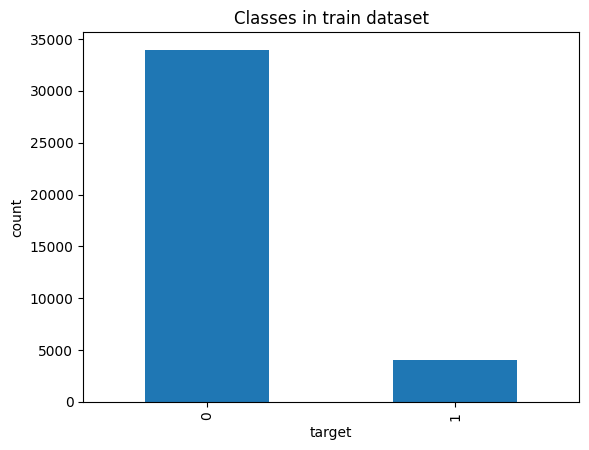

In [ ]:
tmp_df1 = pd.DataFrame({"image_name": os.listdir(data_dir / "train/melanoma"), "target": 1})
tmp_df2 = pd.DataFrame({"image_name": os.listdir(data_dir / "train/other"), "target": 0})
tmp_df_comb = pd.concat([tmp_df1, tmp_df2], ignore_index=True)
tmp_df_comb.target.value_counts().plot(kind='bar')
plt.title('Classes in train dataset')
plt.xlabel('target')
plt.ylabel('count')
plt.show()

### Функції для аугментації

In [ ]:
def augment_and_save(img_path, data_augmentation, num_aug, save=True, output_dir=None, add_func=None):
  aug_images_set =[]
  img = load_img(img_path) #завантажує зображення як PIL
  img_arr = img_to_array(img) #конвертує у NumPy
  img_arr = np.expand_dims(img_arr, axis=0)  # додати розмірність - batch
  for i in range(num_aug):
    augmented_img_arr = data_augmentation(img_arr, training=True)
    # augmented_img = keras.utils.array_to_img(augmented_img_arr[0])
    augmented_img = array_to_img(augmented_img_arr[0])   #first in batch
    if add_func is not None:
      augmented_img = add_func(augmented_img)
    aug_images_set.append(augmented_img)
    if save:
      os.makedirs(output_dir, exist_ok=True)
      img_name = os.path.basename(img_path)
      output_path = os.path.join(output_dir, f"{os.path.splitext(img_name)[0]}_aug_{i}.jpg")
      save_img(output_path, augmented_img)
  return aug_images_set

def run_augmentation(data_augmentation, input_dir, output_dir, num_aug, add_func=None):
  for img_name in os.listdir(input_dir):
    if img_name.endswith((".png", ".jpg", ".jpeg")):
      img_path = os.path.join(input_dir, img_name)
      augment_and_save(img_path, data_augmentation, num_aug, save=True, output_dir=output_dir, add_func=add_func)

def run_selective_augmentation(data_augmentation, input_dir, output_dir, num_aug, ratio=0.3, my_seed=42, add_func=None):
  """augmentation of subset"""
  np.random.seed(my_seed)
  images = os.listdir(input_dir)
  images_to_augm = np.random.choice(images, int(len(images)*ratio), replace=False)
  for img_name in images_to_augm:
    if img_name.endswith((".png", ".jpg", ".jpeg")):
      img_path = os.path.join(input_dir, img_name)
      augment_and_save(img_path, data_augmentation, num_aug, save=True, output_dir=output_dir, add_func=add_func)

In [ ]:
def add_files(source_dir, dest_dir):
  os.makedirs(dest_dir, exist_ok=True)
  for file_name in os.listdir(source_dir):
    source_file = os.path.join(source_dir, file_name)
    if os.path.isfile(source_file):
      destination_file = os.path.join(dest_dir, file_name)
      shutil.copyfile(source_file, destination_file)

## Додавання чорного фону

In [ ]:
def add_vignette(image_path, intensity=0.9, window_radius_ratio=1):
    """
    Додати вин'єтку (чорну рамку) навколо зображення.
    :param intensity: інтенсивність затемнення.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image is not loaded")
    h, w = image.shape[:2]
    y, x = np.mgrid[0:h, 0:w]
    cx, cy = w // 2, h // 2
    # Радіальна градієнтна маска
    window_radius = int(min(cx, cy)*window_radius_ratio)
    distance = np.sqrt((x - cx)**2 + (y - cy)**2)
    mask = np.ones((h, w), dtype=np.float32)
    mask[distance > window_radius] = 1 - intensity
    mask = cv2.merge([mask, mask, mask]).astype(np.float32)  # Для 3-х каналів

    vignette_image = (image * mask).astype(np.uint8)
    # масив NumPy, який містить зображення в форматі RGB
    vignette_image = cv2.cvtColor(vignette_image, cv2.COLOR_BGR2RGB)
    # pil_vignette_image = Image.fromarray(vignette_image) #перетворити у PIL
    return vignette_image

In [ ]:
class VignetteLayer(layers.Layer):
    def __init__(self, intensity=(0.4, 1), window_radius_ratio=(0.85, 1),**kwargs):
        super().__init__(**kwargs)

        self.intensity_range = intensity
        self.window_radius_range = window_radius_ratio
        # self.blur_kernel_size = blur_kernel_size  # (odd number, the less - the sharper)

    def call(self, image):

        input_shape = tf.shape(image)
        batch_size = input_shape[0]
        h = tf.cast(input_shape[1], tf.int32)
        w = tf.cast(input_shape[2], tf.int32)

        intensities = tf.random.uniform((batch_size,), self.intensity_range[0], self.intensity_range[1])
        window_radius_ratios = tf.random.uniform((batch_size,), self.window_radius_range[0], self.window_radius_range[1])

        # h, w = image_np.shape[:2]
        y, x = tf.meshgrid(tf.range(h), tf.range(w), indexing='ij')
        y, x = tf.cast(y, tf.float32), tf.cast(x, tf.float32)
        cx, cy = tf.cast(w / 2, tf.float32), tf.cast(h / 2, tf.float32)
        distance = tf.sqrt((x - cx)**2 + (y - cy)**2)

        masks = []
        for i in range(batch_size):
          window_radius_ratio = window_radius_ratios[i]
          intensity = intensities[i]

          window_radius = tf.minimum(cx, cy) * window_radius_ratio

          mask = tf.ones((h, w), dtype=tf.float32)
          mask = tf.where(distance > window_radius, 1 - intensity, mask)

          mask = tf.expand_dims(mask, axis=-1)  # channels axis (h, w, 1)
          mask = tf.image.resize(mask, [h, w], method="gaussian")  # blur by resize
          masks.append(mask)

        mask_tensor = tf.stack(masks, axis=0)  # (batch_size, h, w, 1)

        vignette_image = image * mask_tensor

        return vignette_image

    def compute_output_shape(self, input_shape):
      return input_shape


In [ ]:
data_augmentation_masked = keras.Sequential(
     [
      # layers.RandomFlip(mode="horizontal_and_vertical"),
      layers.RandomRotation(0.3),
      # layers.RandomShear(x_factor=0.2, y_factor=0.2, fill_mode="nearest"),
      layers.RandomColorJitter(
          value_range=(0, 255),
          brightness_factor=0.1,
          contrast_factor=0.1,
          saturation_factor=(0.46, 0.54),
          hue_factor=0.05),
      VignetteLayer(intensity=(0.5, 1), window_radius_ratio=(0.8, 1))
    ]
)

In [ ]:
# rate = 0.187
# source_path = pathlib.Path("/content/2019_train_other_split/not_vignette")
# dest_path = pathlib.Path("/content/2019_train_other_selection")
# my_seed = 42
# make_sructured_subset(rate, source_path, dest_path, my_seed, copy=True)

In [ ]:
# show_dirs_len(dest_path)

.: 3329


In [ ]:
input_dir = pathlib.Path("/content/2019_train_other_split/not_vignette")
output_dir = pathlib.Path("/content/augmented")
np.random.seed(42)

### Тестування методів аугментації

З використанням шару VignetteLayer

In [ ]:
augm_example = np.random.choice(os.listdir(input_dir), 3)[2]
augm_example_path = os.path.join(input_dir, augm_example)
augm_example_set = augment_and_save(augm_example_path, data_augmentation_masked, 5, save=False)
augm_example_set = [Image.open(augm_example_path)] + augm_example_set

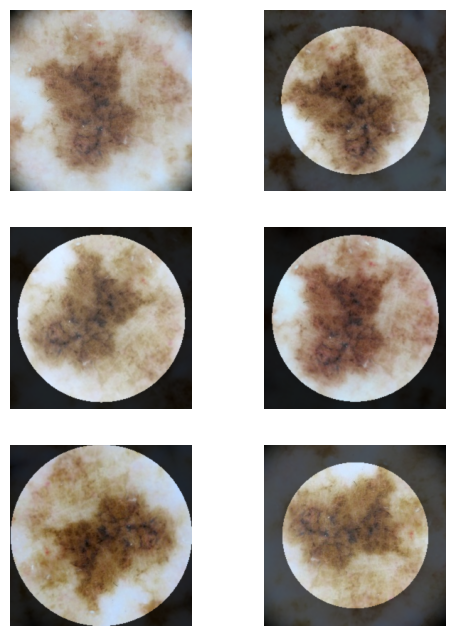

In [ ]:
plt.figure(figsize=(6, 8))
for i, image in enumerate(augm_example_set):
  ax = plt.subplot(3, 2, i + 1)
  plt.imshow(img_to_array(image).astype("uint8"))
  plt.axis("off")


З використанням функції add_vignette

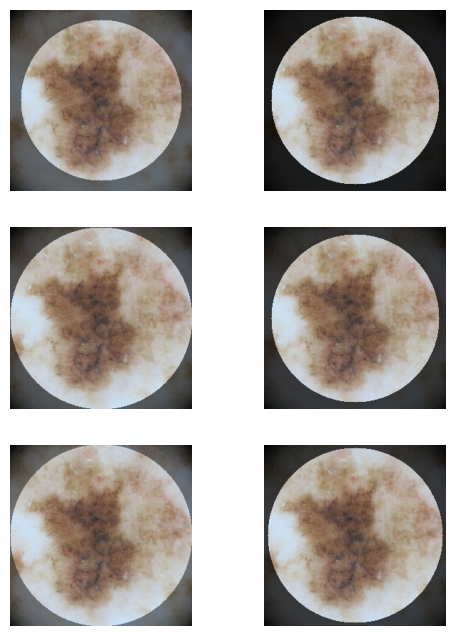

In [ ]:
image = cv2.imread(augm_example_path)
augm_example_set = []
for _ in range(6):
  window_radius_ratio = np.random.choice(np.linspace(0.85, 1, 5), 1)[0] # конверація типу з 1d масиву у число
  intensity = np.random.choice(np.linspace(0.4, 1, 10), 1)[0]
  vignetted_image = add_vignette(augm_example_path, intensity=intensity, window_radius_ratio=window_radius_ratio)
  augm_example_set.append(vignetted_image)

plt.figure(figsize=(6, 8))
for i, image in enumerate(augm_example_set):
  ax = plt.subplot(3, 2, i + 1)
  plt.imshow(img_to_array(image).astype("uint8"))
  plt.axis("off")

Для додавання фону обрано використання шару VignetteLayer

Вибрати частину зображень з тренувального набору 2019 без чорного фону ~ 3337 шт. (18,7%), зробити аугментацію з накладанням чорного фону та додати до тренувального набору.

In [ ]:
run_selective_augmentation(data_augmentation_masked, input_dir, output_dir, 1, ratio=0.187, my_seed=42)

In [ ]:
show_dirs_len(output_dir)

.: 3329


Аугментація з чорним фоном виконана для 3329 зображень.

In [ ]:
# додати аугментовані файли у train/other
dest_dir = pathlib.Path("/content/2020_supplemented/train/other")
add_files(output_dir, dest_dir)

In [ ]:
show_dirs_len(data_dir)

.: 3
validation: 2
validation/melanoma: 1018
validation/other: 1018
train: 2
train/melanoma: 4075
train/other: 37386
test: 2
test/melanoma: 1587
test/other: 10638


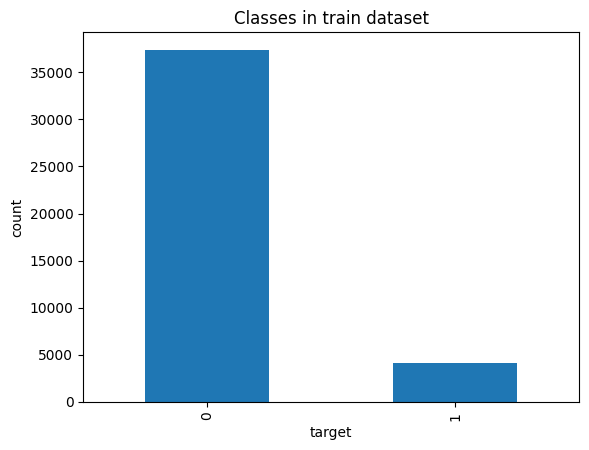

In [ ]:
tmp_df1 = pd.DataFrame({"image_name": os.listdir(data_dir / "train/melanoma"), "target": 1})
tmp_df2 = pd.DataFrame({"image_name": os.listdir(data_dir / "train/other"), "target": 0})
tmp_df_comb = pd.concat([tmp_df1, tmp_df2], ignore_index=True)
tmp_df_comb.target.value_counts().plot(kind='bar')
plt.title('Classes in train dataset')
plt.xlabel('target')
plt.ylabel('count')
plt.show()

In [ ]:
# зберегти за потреби аугментовані зображення
!zip -q -r 2019_train_other_augmmasked.zip . -i /augmented/*
from google.colab import files
files.download("2019_train_other_augmmasked.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# зберегти за потреби доповнений датасет
!zip -q -r 2020_suplemented2.zip . -i /2020_supplemented/*
from google.colab import files
files.download("2020_suplemented2.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Створення вибірки з основного датасету для навчання на меншій кількості даних

In [ ]:
# select different proportion for train, valid and test datasets in small subset
subset_path = pathlib.Path("/content/small_subset")
rates_per_ds = {
    "train": 0.3,
    "validation": 1.0,
    "test": 0.7,
}
make_custom_sructured_subset(data_dir, subset_path, 40, rates_per_ds)

In [ ]:
show_dirs_len(subset_path)

.: 3
train: 2
train/other: 10217
train/melanoma: 1222
validation: 2
validation/other: 1018
validation/melanoma: 1018
test: 2
test/other: 7446
test/melanoma: 1110


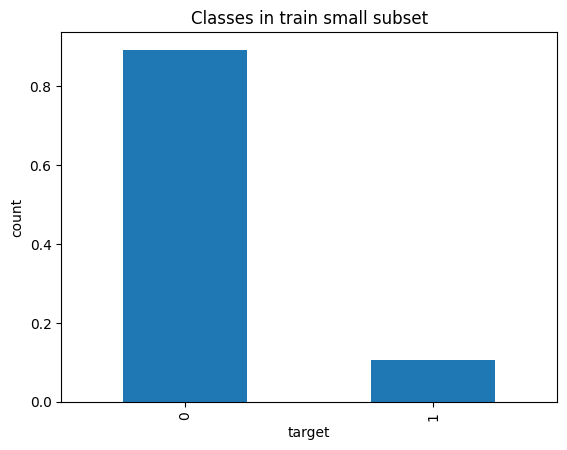

In [ ]:
tmp_df1 = pd.DataFrame({"image_name": os.listdir(subset_path / "train/melanoma"), "target": 1})
tmp_df2 = pd.DataFrame({"image_name": os.listdir(subset_path / "train/other"), "target": 0})
tmp_df_comb = pd.concat([tmp_df1, tmp_df2], ignore_index=True)
tmp_df_comb.target.value_counts(normalize=True).plot(kind='bar')
plt.title('Classes in train small subset')
plt.xlabel('target')
plt.ylabel('count')
plt.show()

## Аугментація цільового класу для збалансування набору

In [ ]:
data_augmentation = keras.Sequential(
    [ layers.RandomFlip(mode="horizontal_and_vertical"),
      layers.RandomRotation(0.5),
      layers.RandomZoom(0.3),
      layers.RandomShear(x_factor=0.2, y_factor=0.2, fill_mode="nearest"),
      # layers.MixUp(alpha=0.2),
      layers.RandomColorJitter(
          value_range=(0, 255),
          brightness_factor=0.1,
          contrast_factor=0.1,
          saturation_factor=(0.46, 0.54),
          hue_factor=0.05)
    ]
)

In [ ]:
# shutil.rmtree("/content/augmented")

In [ ]:
input_dir = pathlib.Path("/content/small_subset/train/melanoma")
output_dir = pathlib.Path("/content/augmented")

Аугментація зображень з тренувального набору (вибірка) для класу "меланома".

In [ ]:
np.random.seed(42)
augm_example = np.random.choice(os.listdir(input_dir), 1)[0]
augm_example_path = os.path.join(input_dir, augm_example)
augm_example_set = augment_and_save(augm_example_path, data_augmentation, 5, save=False)
augm_example_set = [Image.open(augm_example_path)] + augm_example_set

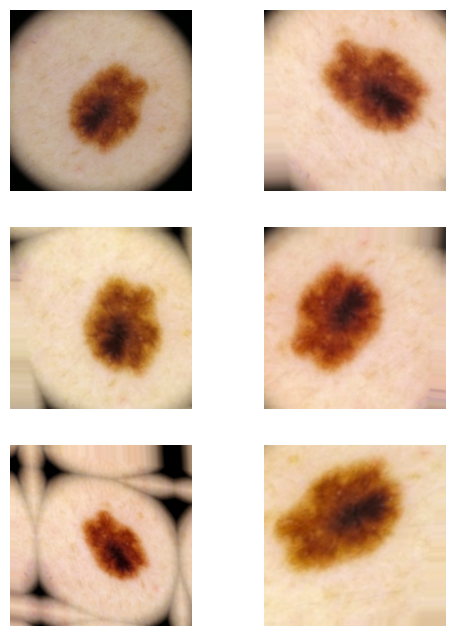

In [ ]:
plt.figure(figsize=(6, 8))
for i, image in enumerate(augm_example_set):
  ax = plt.subplot(3, 2, i + 1)
  plt.imshow(img_to_array(image).astype("uint8"))
  plt.axis("off")

In [ ]:
run_augmentation(data_augmentation, input_dir, output_dir, 4)

In [ ]:
show_dirs_len(output_dir)

.: 4888


In [ ]:
# зберегти за потреби аугментовані зображення
!zip -q -r 2020_train_melanoma_augmented_sub4_crop.zip . -i /augmented/*
from google.colab import files
files.download("2020_train_melanoma_augmented_sub4_crop.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# зберегти за потреби вибірку без аугментації
!zip -q -r small_subset_crop.zip content/small_subset/
from google.colab import files
files.download("small_subset_crop.zip")


zip error: Nothing to do! (try: zip -q -r 2020_small_subset.zip . -i ./content/small_subset/)


In [ ]:
# додати аугментовані файли у вибірку
add_files(output_dir, input_dir)

In [ ]:
show_dirs_len(input_dir)

.: 6110


In [ ]:
show_dirs_len(subset_path)

.: 3
test: 2
test/melanoma: 1110
test/other: 12284
train: 2
train/melanoma: 6110
train/other: 10187
validation: 2
validation/melanoma: 1018
validation/other: 1118


In [ ]:
# зберегти вибірку з аугментацією цільового класу
!zip -q -r small_subset_with_augm4_crop.zip /content/small_subset
from google.colab import files
files.download("small_subset_with_augm4_crop.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

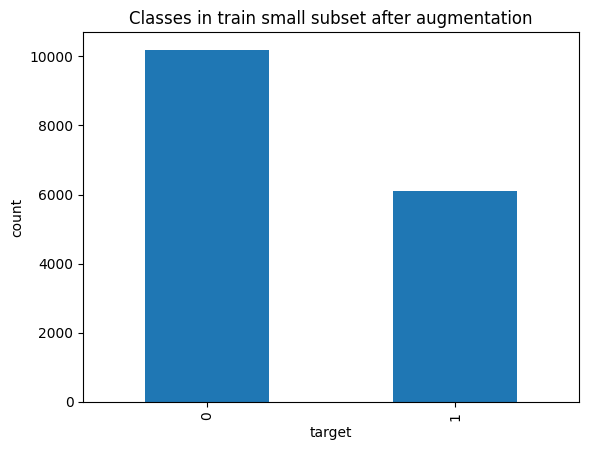

In [ ]:
tmp_df1 = pd.DataFrame({"image_name": os.listdir(subset_path / "train/melanoma"), "target": 1})
tmp_df2 = pd.DataFrame({"image_name": os.listdir(subset_path / "train/other"), "target": 0})
tmp_df_comb = pd.concat([tmp_df1, tmp_df2], ignore_index=True)
tmp_df_comb.target.value_counts().plot(kind='bar')
plt.title('Classes in train small subset after augmentation')
plt.xlabel('target')
plt.ylabel('count')
plt.show()

## Завантаження даних для навчання

In [ ]:
# датасет з аугментацією 1:4
# https://drive.google.com/file/d/1G_RxTPmtMMJIQQifoaCsfsJZu-mou6uX/view?usp=sharing
file_id = "1G_RxTPmtMMJIQQifoaCsfsJZu-mou6uX"
url = f"https://drive.google.com/uc?id={file_id}"
output = "small_subset_with_augm4_crop.zip"

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1G_RxTPmtMMJIQQifoaCsfsJZu-mou6uX
From (redirected): https://drive.google.com/uc?id=1G_RxTPmtMMJIQQifoaCsfsJZu-mou6uX&confirm=t&uuid=a39e0d28-3c48-4fb9-a547-1fe2a82f6777
To: /content/small_subset_with_augm4_crop.zip
100%|██████████| 1.00G/1.00G [00:16<00:00, 61.4MB/s]


'small_subset_with_augm4_crop.zip'

In [ ]:
!unzip -q small_subset_with_augm4_crop.zip

In [ ]:
small_data_dir = pathlib.Path("/content/content/small_subset")
show_dirs_len(small_data_dir)

.: 3
train: 2
train/other: 10187
train/melanoma: 6110
test: 2
test/other: 12284
test/melanoma: 1110
validation: 2
validation/other: 1118
validation/melanoma: 1018


In [ ]:
# small_data_dir =  pathlib.Path("/Source/content/small_subset")
# show_dirs_len(small_data_dir)

.: 3
test: 2
test\melanoma: 1110
test\other: 7446
train: 2
train\melanoma: 6110
train\other: 9328
validation: 2
validation\melanoma: 1018
validation\other: 1018


In [ ]:
# small_data_dir

WindowsPath('C:/Users/11/Desktop/1UNIVER/Diploma/Source/content/small_subset')

## Визначення параметрів, функцій для побудови моделі

In [ ]:
def generate_model_version_name():

  from datetime import datetime

  now = datetime.now()
  month_day = now.strftime("%m-%d")  # Формат: ММ-ДД
  hours = now.strftime("%H")  # Формат: ЧЧ, тільки години
  return month_day + "-" + hours

In [ ]:
# при дисбалансі класів
def binary_class_weights(dataset):
  count_1 = 0
  count_0 = 0
  for items, labels in dataset:
    labels = labels.numpy()
    count_1 += np.sum(labels==1)
    count_0 += np.sum(labels==0)
  weight_1 = (1/count_1) * ((count_1+count_0)/2.0)
  weight_0 = (1/count_0) * ((count_1+count_0)/2.0)
  return (weight_0, weight_1)

def initial_bias_calc(dataset):
  count_1 = 0
  count_0 = 0
  for items, labels in dataset:
    labels = labels.numpy()
    count_1 += np.sum(labels==1)
    count_0 += np.sum(labels==0)
  weight_1 = (1/count_1) * ((count_1+count_0)/2.0)
  weight_0 = (1/count_0) * ((count_1+count_0)/2.0)
  return np.log([count_1/count_0])


In [ ]:
# при дисбалансі класів при відомій кількості екземплярів кожного класу
def binary_class_weights_2(count_1, count_0):
  weight_1 = (1/count_1) * ((count_1+count_0)/2.0)
  weight_0 = (1/count_0) * ((count_1+count_0)/2.0)
  return (weight_0, weight_1)

def initial_bias_calc_2(count_1, count_0):
  weight_1 = (1/count_1) * ((count_1+count_0)/2.0)
  weight_0 = (1/count_0) * ((count_1+count_0)/2.0)
  return np.log(count_1/count_0)

In [ ]:
# логування
import csv
from tensorflow.keras.callbacks import Callback

# зібрати під час навчання метрики
class MetricsLogger(Callback):
    def __init__(self, filepath):
        super().__init__()
        self.filepath = filepath
        self.metrics = None
        # create file on init
        with open(self.filepath, mode='w', newline='') as f:
            writer = csv.writer(f)
    # method Callbak class
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # get logs keys
        if self.metrics is None:
          self.metrics = list(logs.keys())
            # add metrics header to csv
          with open(self.filepath, mode='a', newline='') as f:
              writer = csv.writer(f)
              writer.writerow(['epoch'] + self.metrics)
        with open(self.filepath, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([epoch] + [logs[m] for m in self.metrics])

In [ ]:
# візуалізація
def plot_scores (df, model_name, metrics_list):
  n = len(metrics_list)
  fig = plt.figure(figsize=(16, int(np.ceil(n/3)*4) ))
  fig.suptitle(f'{model_name}')
  for i, metric in enumerate(metrics_list):
    ax = plt.subplot(int(np.ceil(n/3)), 3, i + 1)
    ax.plot(df.index+1, df[metric], label=metric)
    ax.plot(df.index+1, df["val_" + metric], label="val_" + metric)
    ax.legend(loc='lower right')
    ax.grid(True)
  fig2 = plt.figure(figsize=(8, 6))
  for i, metric in enumerate(metrics_list):
    plt.plot(df.index+1, df[metric], label=metric)
    plt.plot(df.index+1, df["val_" + metric], label="val_" + metric)
  plt.legend(loc='lower right')
  plt.show();

def plot_loss(df, model_name):
  fig = plt.figure(figsize=(8, 6))
  fig.suptitle(f'{model_name + " loss"}')
  plt.plot(df.index+1, df['loss'], label='train loss')
  plt.plot(df.index+1, df["val_loss"], label="validation loss")
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.show();

In [ ]:
def plot_confusion_matrix(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["other", "melanoma"])
  disp.plot(cmap=plt.cm.Blues)
  plt.xlabel("Predictions")
  plt.ylabel("Actual")
  plt.title('Confusion matrix')
  plt.show()

In [ ]:
def fbeta_metric(precision, recall, beta=2.0):
  return precision * recall * (1+beta**2)/( (beta**2) * precision + recall)

In [ ]:
# IM_SIZE = 256
BATCH_SIZE = 32
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR') # precision-recall curve
]
VERSION = generate_model_version_name()
# MODEL_NAME = f"Basic_model_{VERSION}"
LEARNING_RATE = 1e-4

In [ ]:
VERSION

'04-18-12'

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  small_data_dir / "train",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  shuffle=True,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  small_data_dir / "validation",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
  small_data_dir / "test",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  batch_size=BATCH_SIZE)

Found 16297 files belonging to 2 classes.
Found 2136 files belonging to 2 classes.
Found 13394 files belonging to 2 classes.


### Візуалізація датасету

In [ ]:
class_names = train_ds.class_names
print(class_names)

['other', 'melanoma']


In [ ]:
print(train_ds)
print(val_ds)
print(test_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


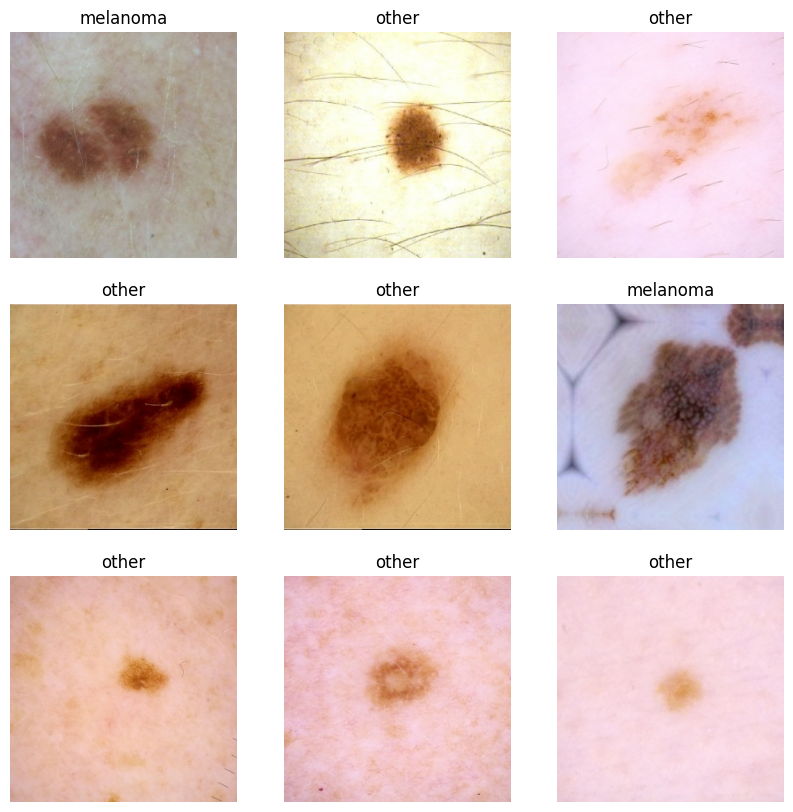

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Створення моделі, передобробка датасету, навчання, оцінка

In [ ]:
# Configure the dataset for performance
train_ds = train_ds.shuffle(64).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

### при дисбалансі класів

In [ ]:
count_1 = len(os.listdir(small_data_dir / "train/melanoma"))
count_0 = len(os.listdir(small_data_dir / "train/other"))

In [ ]:
# weight_0, weight_1 = binary_class_weights(train_ds)
weight_0, weight_1 = binary_class_weights_2(count_1, count_0)

class_weights = {0: weight_0, 1: weight_1}

print(f'Weight for class 0: {weight_0:.2f}')
print(f'Weight for class 1: {weight_1:.2f}')

Weight for class 0: 0.80
Weight for class 1: 1.33


In [ ]:
# initial_bias = initial_bias_calc(train_ds)
initial_bias = initial_bias_calc_2(count_1, count_0)
print(f'initial_bias: {initial_bias}')

initial_bias: -0.5111856244244254


### Модель

In [ ]:
# створення та компіляція моделі з заданим bias для останнього шару
def make_model(learning_rate=1e-3, metrics=METRICS, model=None, output_bias=None):
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
  if output_bias is not None:
    model.layers[-1].bias.assign([output_bias])
  return model

In [ ]:
MODEL_NAMES = [f"MobileNetV2_{VERSION}",
              f"Xception_{VERSION}",
              f"ResNet50V2_{VERSION}",
              f"InceptionV3_{VERSION}",
               f"ConvNeXtTiny_{VERSION}",
               f"DenseNet121_{VERSION}",
               f"NASNetMobile_{VERSION}",
               f"EfficientNetV2B0_{VERSION}"]

In [ ]:
# ! Перезапускати
model_index = 7
MODEL_NAME = MODEL_NAMES[model_index]

In [ ]:
MODEL_NAME

'EfficientNetV2B0_04-18-12'

In [ ]:
if model_index == 0:
  from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
  IM_SIZE = 256       #224
  base_model = MobileNetV2(
    weights="imagenet",
    input_shape=(IM_SIZE, IM_SIZE, 3),
    include_top=False)

if model_index == 1:
  from keras.applications.xception import Xception, preprocess_input
  IM_SIZE = 256   #229
  base_model = Xception(
    weights="imagenet",
    input_shape=(IM_SIZE, IM_SIZE, 3),
    include_top=False)

if model_index == 2:
  from keras.applications.resnet_v2 import ResNet50V2, preprocess_input
  IM_SIZE = 256   #224
  base_model = ResNet50V2(
    weights="imagenet",
    input_shape=(IM_SIZE, IM_SIZE, 3),
    include_top=False)

if model_index == 3:
  from keras.applications.inception_v3 import InceptionV3, preprocess_input
  IM_SIZE = 256   #229
  base_model = InceptionV3(
    weights="imagenet",
    input_shape=(IM_SIZE, IM_SIZE, 3),
    include_top=False)

if model_index == 4:
  from keras.applications.convnext import ConvNeXtTiny, preprocess_input
  IM_SIZE = 256
  base_model = ConvNeXtTiny(
    weights="imagenet",
    input_shape=(IM_SIZE, IM_SIZE, 3),
    include_top=False)

if model_index == 5:
  from keras.applications.densenet import DenseNet121, preprocess_input
  IM_SIZE = 256   #224
  base_model = DenseNet121(
    weights="imagenet",
    input_shape=(IM_SIZE, IM_SIZE, 3),
    include_top=False)

if model_index == 6:
  from keras.applications.nasnet import NASNetMobile, preprocess_input
  IM_SIZE = 256    #224
  base_model = NASNetMobile(
    weights="imagenet",
    input_shape=(IM_SIZE, IM_SIZE, 3),
    include_top=False)

if model_index == 7:
  from keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
  IM_SIZE = 256
  base_model = EfficientNetV2B0(
    weights="imagenet",
    input_shape=(IM_SIZE, IM_SIZE, 3),
    include_top=False)

print(base_model.output_shape)

# preprocess for fine_tuning:
def preprocess(image, label):
  image = preprocess_input(image)
  return image, label

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(None, 8, 8, 1280)


In [ ]:
# заморозити шари базової моделі
base_model.trainable = False

In [ ]:
# train_ds = train_ds.map(preprocess)
# val_ds = val_ds.map(preprocess)
# test_ds = test_ds.map(preprocess)

In [ ]:
# модель
inputs = keras.Input(shape=(IM_SIZE, IM_SIZE, 3))
preprocessed = layers.Lambda(preprocess_input)(inputs)
x = base_model(preprocessed, training=False)  #to keep batchnorm layers in inference mode, when unfreeze the base model for fine-tuning
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu', name="full_con1")(x)
outputs = keras.layers.Dense(1, activation='sigmoid', name="pred")(x)
model = keras.Model(inputs, outputs)

## EfficientNetV2B0

! оновити визначення версії, моделі, індекс, базова модель, модель

### Transfer learning

In [ ]:
labels = ['tl-', 'ft-']
label = labels[0]
print(label, MODEL_NAME)

# створення та компіляція transfer learning моделі
tl_model = make_model(metrics=METRICS, model=model, output_bias=initial_bias)
model.summary(show_trainable=True)

tl- EfficientNetV2B0_04-18-12


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ lambda (Lambda)             │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetv2-b0           │ (None, 8, 8, 1280)    │  5,919,312 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ full_con1 (Dense)           │ (None, 128)           │    163,968 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ pred (Dense)                │ (None, 1)             │        129 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 6,083,409 (23.21 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
metrics_logger = MetricsLogger(filepath=f"metrics_logs_{label}{MODEL_NAME}.csv")

callbacks_list = [EarlyStopping(monitor='val_accuracy', patience=6),
                  ModelCheckpoint(f'small-{label}{MODEL_NAME}.keras', monitor='val_loss', save_best_only=True),
                  metrics_logger,
                  # WandbMetricsLogger(),
                  # WandbModelCheckpoint(filepath=f"small-{label}{MODEL_NAME}_wandb.keras", monitor="val_loss")
]

epochs=20

In [ ]:
# EfficientNetV2B0
history = tl_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks_list,
  class_weight=class_weights
)

Epoch 1/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 103s 118ms/step - accuracy: 0.9105 - auc: 0.9583 - fn: 322.8787 - fp: 311.6790 - loss: 0.2368 - prc: 0.9518 - precision: 0.8819 - recall: 0.8755 - tn: 4795.2466 - tp: 2760.7827 - val_accuracy: 0.8043 - val_auc: 0.9427 - val_fn: 387.0000 - val_fp: 31.0000 - val_loss: 0.4508 - val_prc: 0.9386 - val_precision: 0.9532 - val_recall: 0.6198 - val_tn: 1087.0000 - val_tp: 631.0000
Epoch 2/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 27s 47ms/step - accuracy: 0.9447 - auc: 0.9836 - fn: 242.9100 - fp: 214.4618 - loss: 0.1521 - prc: 0.9801 - precision: 0.9304 - recall: 0.9209 - tn: 4905.5283 - tp: 2827.4619 - val_accuracy: 0.7903 - val_auc: 0.9504 - val_fn: 430.0000 - val_fp: 18.0000 - val_loss: 0.4776 - val_prc: 0.9495 - val_precision: 0.9703 - val_recall: 0.5776 - val_tn: 1100.0000 - val_tp: 588.0000
Epoch 3/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 39s 47ms/step - accuracy: 0.9491 - auc: 0.9866 - fn: 226.3973 - fp: 192.5773 - loss: 0.1379 - prc: 0.9833 - precision: 0.9369 - re

In [ ]:
from google.colab import files

df_basic = pd.DataFrame(history.history)
df_basic.to_csv(f"metrics_{label}{MODEL_NAME}.csv", index=False)

files.download(f'/content/metrics_logs_{label}{MODEL_NAME}.csv')
files.download(f'/content/small-{label}{MODEL_NAME}.keras')
files.download(f'/content/metrics_{label}{MODEL_NAME}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

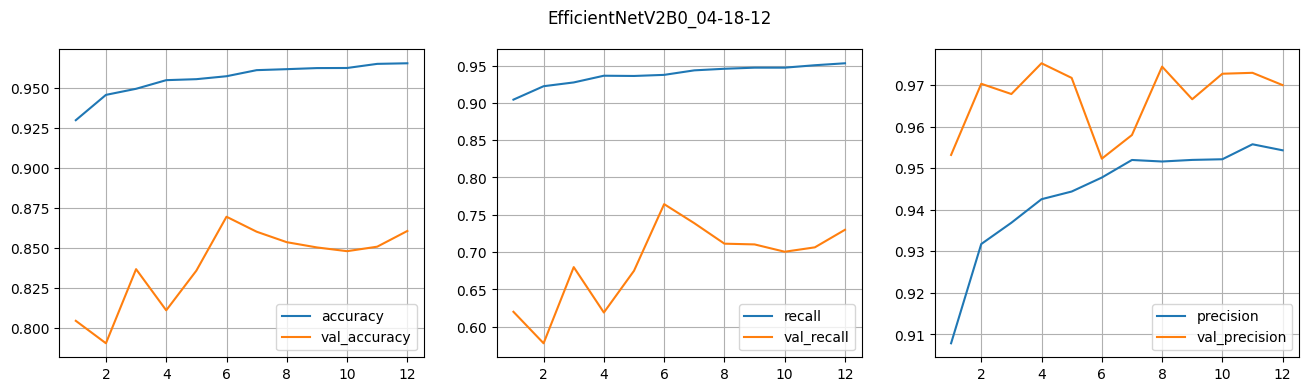

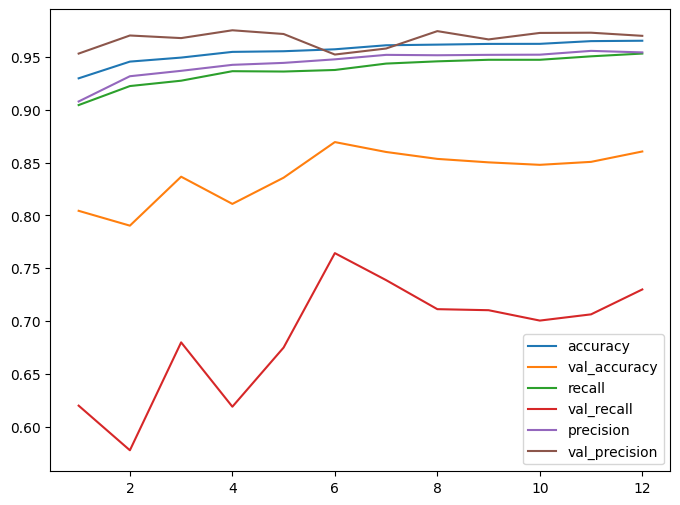

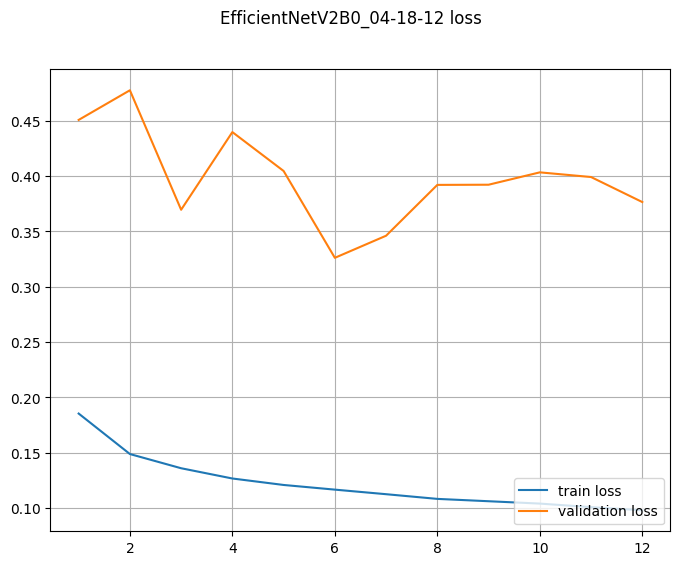

In [ ]:
plot_scores (df_basic, MODEL_NAME, ['accuracy', 'recall', 'precision'])
plot_loss(df_basic, MODEL_NAME)

In [ ]:
model_path = f"/content/small-tl-{MODEL_NAME}.keras"
best_tl_model = keras.models.load_model(model_path, custom_objects={"preprocess_input": preprocess_input})

best_tl_results = best_tl_model.evaluate(test_ds, verbose=1)

precision = best_tl_results[2]
recall = best_tl_results[3]
fbeta = fbeta_metric(precision, recall)
best_tl_results.append(fbeta)

419/419 ━━━━━━━━━━━━━━━━━━━━ 32s 60ms/step - accuracy: 0.7817 - auc: 0.7727 - fn: 260.9405 - fp: 1194.8500 - loss: 0.5688 - prc: 0.2215 - precision: 0.1842 - recall: 0.5147 - tn: 4992.5713 - tp: 287.4952


In [ ]:
for metric, value in zip(["loss"] + [m.name for m in METRICS] + ["f1_beta"], best_tl_results):
  print(metric, ': ', value)
print()

loss :  0.5675784945487976
accuracy :  0.7832611799240112
precision :  0.19845274090766907
recall :  0.5315315127372742
tp :  590.0
fp :  2383.0
tn :  9901.0
fn :  520.0
auc :  0.777927041053772
prc :  0.24160152673721313
f1_beta :  0.39794953931675897



In [ ]:
# Зберегти результат оцінки на тествому наборі
df_eval = pd.DataFrame({'Metric': ["loss"] + [m.name for m in METRICS] + ["f1_beta"], 'Value': best_tl_results})
df_eval.to_csv(f'evaluate_results_{label}{MODEL_NAME}.csv', index=False)
files.download(f'/content/evaluate_results_{label}{MODEL_NAME}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def get_predictions_df(model, img_size=(256, 256), batch_size=32, images_folder=None, dataset=None, threshold = 0.5):
  if images_folder is not None:
    dataset = tf.keras.utils.image_dataset_from_directory(
    images_folder,
    label_mode=None,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
    )
  # get filenames, dataset.file_paths
  file_paths = dataset.file_paths

  predictions = model.predict(dataset, verbose=0)
  predicted_labels = (predictions >= threshold).astype(int)
  true_labels = [0 if 'other' in fp else 1 for fp in file_paths]

  predictions_df = pd.DataFrame({
      'file_path': file_paths,
      'true_label': true_labels,
      'predicted_label': np.concatenate(np.array(predicted_labels), axis=0),
      'predicted_prob': np.concatenate(np.array(predictions), axis=0)
  })
  return predictions_df

In [ ]:
def show_predicted(images_pathes):
  num = len(images_pathes)
  plt.figure(figsize=(16, np.ceil(num/5)*3.5))

  for i, im in enumerate(images_pathes):
    ax = plt.subplot(int(np.ceil(num/5)), 5, i + 1)
    image = Image.open(im)
    plt.imshow(img_to_array(image).astype("uint8"))
    plt.title(f"{predictions_df.file_path[predictions_df['file_path']==im].values[0][-16:]} ,\n, True: {predictions_df.true_label[predictions_df['file_path']==im].values[0]}, Predicted: {predictions_df.predicted_prob[predictions_df['file_path']==im].values[0]: .2f}")
    plt.axis("off")

In [ ]:
images_folder = pathlib.Path('/content/content/small_subset/test')
predictions_df = get_predictions_df(best_tl_model, img_size=(256, 256), batch_size=32, images_folder=images_folder)

Found 13394 files.


In [ ]:
predictions_df.to_csv(f'Predictions_{label}-{MODEL_NAME}_cropped.csv', index=False)
from google.colab import files
files.download(f'Predictions_{label}-{MODEL_NAME}_cropped.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
mask_fp = (predictions_df['true_label'] == 0) & (predictions_df['predicted_label'] == 1)
mask_fn = (predictions_df['true_label'] == 1) & (predictions_df['predicted_label'] == 0)
mask_tn = (predictions_df['true_label'] == 0) & (predictions_df['predicted_label'] == 0)
mask_tp = (predictions_df['true_label'] == 1) & (predictions_df['predicted_label'] == 1)
fp_images_pathes = predictions_df.file_path[mask_fp]
fn_images_pathes = predictions_df.file_path[mask_fn]
tp_images_pathes = predictions_df.file_path[mask_tp]
tn_images_pathes = predictions_df.file_path[mask_tn]
print(f'FP: {len(fp_images_pathes)}, FN: {len(fn_images_pathes)}')
print(f'TP: {len(tp_images_pathes)}, TN: {len(tn_images_pathes)}')

FP: 2383, FN: 520
TP: 590, TN: 9901


In [ ]:
# Візуалізація FP
print("False Positive:")
show_predicted(fp_images_pathes[:-20])

False Negative:


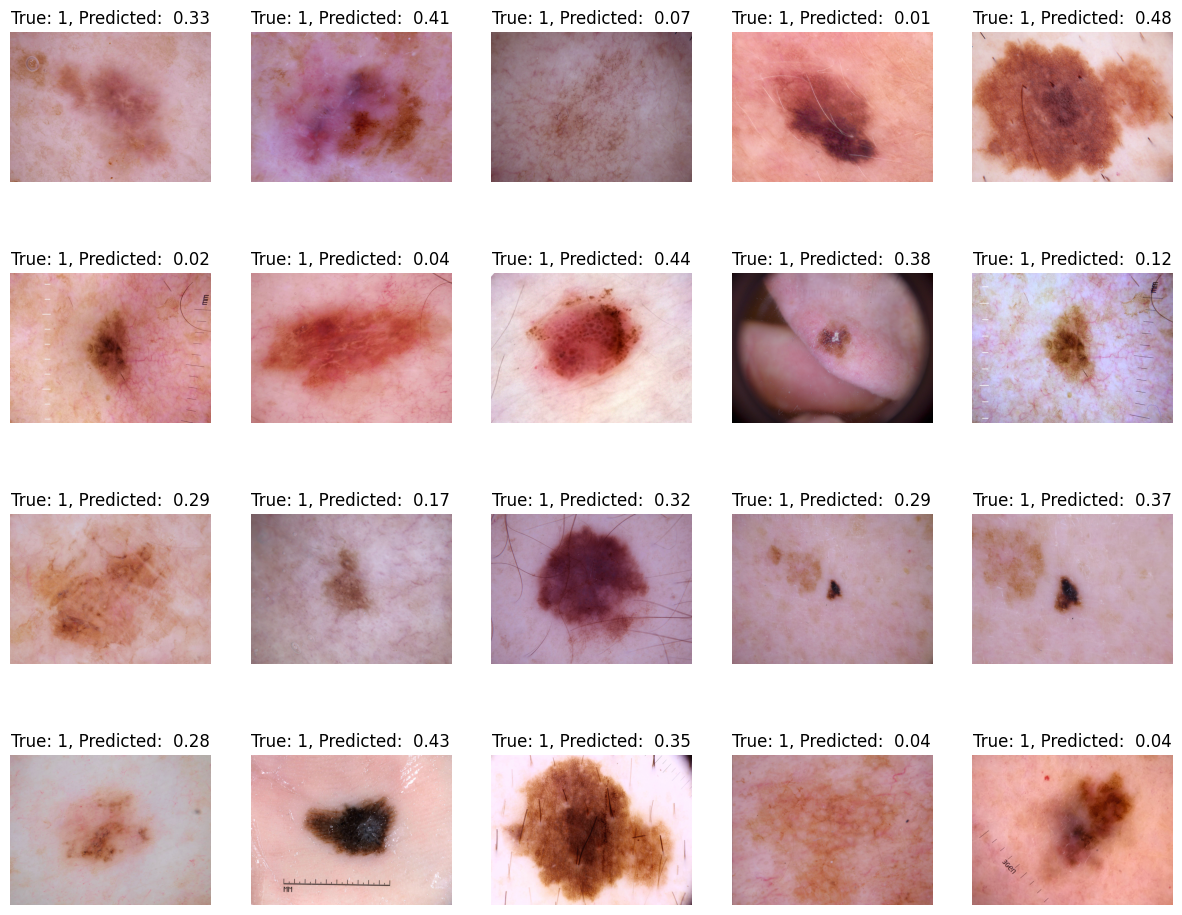

In [ ]:
# Візуалізація FP
print("False Negative:")
show_predicted(fn_images_pathes[:20])

## Обрізка тестових даних та перевірка

In [ ]:
def crop_black_frame(image_np, threshold=20):
    """
    Обрізати чорні края по периметру, ресайз до вихідного розміру.
        image: RGB NumPy image (H, W, 3)
        threshold: Порог яскравості, нижче якого вважається "чорним"
    """

    h, w = image_np.shape[:2]
    original_size = (w, h)
    radius = min(h, w) // 2 - 1 #зменшення на 1

    gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)

    mask = gray > threshold

    coords = np.argwhere(mask)

    if coords.shape[0] == 0:
        return image_np

    y1, x1 = coords.min(axis=0)
    y2, x2 = coords.max(axis=0)

    margin_y = int(0.05 * (y2 - y1))
    margin_x = int(0.05 * (x2 - x1))

    y1 = max(0, y1 + margin_y)
    y2 = min(h, y2 - margin_y)
    x1 = max(0, x1 + margin_x)
    x2 = min(w, x2 - margin_x)

    image_tf = tf.convert_to_tensor(image_np, dtype=tf.uint8)
    # image_tf = tf.image.decode_jpeg(image, channels=3)
    cropped_tensor = tf.image.crop_to_bounding_box(image_tf, y1, x1, y2-y1, x2-x1)

    resized = tf.image.resize(cropped_tensor, original_size, method=tf.image.ResizeMethod.BILINEAR)
    resized = tf.cast(resized, tf.uint8)

    return resized

In [ ]:
def crop_black_frame_tf(image_tensor, im_size=256, threshold=20):
    """ TensorFlow-сумісна версія crop_black_frame для tf.data. """
    result = tf.numpy_function(
        func=crop_black_frame,
        inp=[image_tensor, threshold],
        Tout=tf.uint8
    )
    result.set_shape([im_size, im_size, 3])
    return result

In [ ]:
def preprocess_image(image, label, im_size=256, threshold=20):
    # image = tf.io.read_file(image_path)
    # image = tf.image.decode_jpeg(image, channels=3)
    image = crop_black_frame_tf(image, im_size, threshold)
    # image = tf.image.resize(image, im_size)
    # image = tf.cast(image, tf.uint8)
    # image.set_shape([None, None, 3])
    return image, label

In [ ]:
test_ds2 = tf.keras.utils.image_dataset_from_directory(
  small_data_dir / "test",
  class_names=["other", "melanoma"],
  seed=123,
  image_size=(IM_SIZE, IM_SIZE),
  batch_size=BATCH_SIZE)

test_ds2 = test_ds2.map(lambda image, label: preprocess_image(image, label, im_size=256))
# test_ds2 = test_ds2.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 13394 files belonging to 2 classes.


In [ ]:
print(test_ds2)

<_MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
best_tl_results = best_tl_model.evaluate(test_ds2, verbose=1)

precision = best_tl_results[2]
recall = best_tl_results[3]
fbeta = fbeta_metric(precision, recall)
best_tl_results.append(fbeta)

for metric, value in zip(["loss"] + [m.name for m in METRICS] + ["f1_beta"], best_tl_results):
  print(metric, ': ', value)
print()

ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(256, 256, 3)

In [ ]:
def crop_and_save(im_path, threshold=20):
  img = cv2.imread(im_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  processed = crop_black_frame(img, threshold)
  encoded_image = tf.image.encode_jpeg(processed)
  tf.io.write_file(im_path, encoded_image)

In [ ]:
def has_black_vignette(image, center_ratio=0.5, threshold=70):
  gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  height, width = gray.shape
  mask = np.zeros((height, width), dtype=np.uint8)
  cv2.circle(mask, (width//2, height//2), int(min(height, width)*center_ratio), 255, -1)
  outside_mask = cv2.bitwise_not(mask)
  avg_brightness = cv2.mean(gray, mask=outside_mask)[0]
  return avg_brightness < threshold

In [ ]:
def separate_vignette_images(directory, center_ratio=0.5, threshold=70):
  has = []
  not_has = []
  for im in os.listdir(directory):
    image_path = directory / im
    image = cv2.imread(image_path)
    if has_black_vignette(image, center_ratio, threshold):
      has.append(image_path)
    else:
      not_has.append(image_path)
  return {"has": has, "not_has": not_has}

In [ ]:
# перевірка папки з test/melanoma
directory = pathlib.Path("/content/content/small_subset/test/melanoma")
dict_test = separate_vignette_images(directory)
print(f"With vignette: {len(dict_test['has'])}")
print(f"Without vignette: {len(dict_test['not_has'])}")
print(len(os.listdir(directory)))

With vignette: 369
Without vignette: 741
1110


In [ ]:
for im_path in dict_test['has']:
  im_path = str(im_path)
  crop_and_save(im_path, threshold=28)

In [ ]:
# перевірка папки з test/other
directory = pathlib.Path("/content/content/small_subset/test/other")
dict_test = separate_vignette_images(directory)
print(f"With vignette: {len(dict_test['has'])}")
print(f"Without vignette: {len(dict_test['not_has'])}")
print(len(os.listdir(directory)))

With vignette: 1414
Without vignette: 10870
12284


In [ ]:
for im_path in dict_test['has']:
  im_path = str(im_path)
  crop_and_save(im_path, threshold=28)

In [ ]:
test_ds2 = tf.keras.utils.image_dataset_from_directory(
  small_data_dir / "test",
  class_names=["other", "melanoma"],
  seed=123,
  image_size=(IM_SIZE, IM_SIZE),
  batch_size=BATCH_SIZE)

test_ds2 = test_ds2.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 13394 files belonging to 2 classes.


In [ ]:
best_tl_results = best_tl_model.evaluate(test_ds2, verbose=1)

precision = best_tl_results[2]
recall = best_tl_results[3]
fbeta = fbeta_metric(precision, recall)
best_tl_results.append(fbeta)

for metric, value in zip(["loss"] + [m.name for m in METRICS] + ["f1_beta"], best_tl_results):
  print(metric, ': ', value)
print()

419/419 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.7746 - auc: 0.8149 - fn: 191.7571 - fp: 1317.3191 - loss: 0.5691 - prc: 0.2601 - precision: 0.2064 - recall: 0.6557 - tn: 4870.1025 - tp: 356.6786
loss :  0.5665973424911499
accuracy :  0.7752724885940552
precision :  0.21556885540485382
recall :  0.6486486196517944
tp :  720.0
fp :  2620.0
tn :  9664.0
fn :  390.0
auc :  0.8201346397399902
prc :  0.2793627381324768
f1_beta :  0.4627249175962268



тестові дані не схожі на ті, на яких модель навчалася, що призводить до низької точності

Тестування на наборі тільки 2020 року з доповненим позитивним класом 2019 року

In [ ]:
# model_path = f"/content/small-tl-{MODEL_NAME}.keras"
model_path = f"/content/small-tl-EfficientNetV2B0_04-18-12.keras"
best_tl_model = keras.models.load_model(model_path, custom_objects={"preprocess_input": preprocess_input})

best_tl_results = best_tl_model.evaluate(test_ds, verbose=1)

precision = best_tl_results[2]
recall = best_tl_results[3]
fbeta = fbeta_metric(precision, recall)
best_tl_results.append(fbeta)

268/268 ━━━━━━━━━━━━━━━━━━━━ 47s 126ms/step - accuracy: 0.9196 - auc: 0.8953 - fn: 260.4164 - fp: 90.2639 - loss: 0.2316 - prc: 0.7063 - precision: 0.7598 - recall: 0.5295 - tn: 3678.0298 - tp: 291.0223


In [ ]:
for metric, value in zip(["loss"] + [m.name for m in METRICS] + ["f1_beta"], best_tl_results):
  print(metric, ': ', value)
print()

loss :  0.23640072345733643
accuracy :  0.9188873171806335
precision :  0.7715404629707336
recall :  0.5324324369430542
tp :  591.0
fp :  175.0
tn :  7271.0
fn :  519.0
auc :  0.8936535120010376
prc :  0.7113178968429565
f1_beta :  0.5676142945455168

